In [1]:
import matplotlib.ticker as ticker

# to change with path suited for you 
results_path = 'results/'
images_path = 'images/'

In [10]:
import pandas as pd 
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from .retrospective_analysis.metrics import max_error, mean_difference

ModuleNotFoundError: No module named 'retrospective_analysis'

In [3]:
import matplotlib as mpl
# Set matplotlib style 
mpl.use("pgf")
mpl.rcParams.update({
    'font.family': 'serif',
    'axes.titlesize' : 25,
    'axes.labelsize' : 19,
    'legend.fontsize' : 18,
    'pgf.rcfonts': False,
    'figure.dpi': 300.0,
})

mpl.rcParams['axes.unicode_minus'] = False
sns.set(font_scale=1.5, style="white", 
        rc={
            'font.family': 'sans-serif',
            'axes.titlesize' : 25,
            'axes.labelsize' : 22,
            'legend.fontsize' : 15,
            'xtick.labelsize' : 17,
            'ytick.labelsize' : 17,
            'xtick.bottom': True,
            'ytick.left': True,
            'figure.dpi': 300.0,
})
%matplotlib inline

In [4]:
# divide by 100 to express as % of normalization
new_hosp_normalization = 4200/100 
icu_normalization = 7000/100 

In [6]:
url = "https://raw.githubusercontent.com/evaluation-modelisation-covid/france/gh-pages/paper_models/data/2020_04_29/corrected_scenarios.csv"

# needed to smooth out day-to-day variations 
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def add_baselines(df, start_date):

  known_data = df[df.index<start_date].reality
  length_of_extrapolation = len(np.where(df.index >= start_date)[0])

  # baseline where we simply impute values using the last observed one 
  last_known_value = known_data[-1]
  last_known_value = moving_average(known_data.values, 7)[-1]
  constant_baseline = [last_known_value for i in range(length_of_extrapolation)]
  
  
  # baseline using Taylor series expansion with first and second order derivatives 
  derivative = np.gradient(moving_average(known_data.values, 7))
  second_order_derivative = np.gradient(derivative)

  first_order_baseline = [last_known_value + derivative[-1]*i for i in range(length_of_extrapolation)]
  second_order_baseline = [last_known_value + derivative[-1]*i + 0.5*second_order_derivative[-1]*i**2 for i in range(length_of_extrapolation)]
  
  df["Constant"] = [x for x in known_data] + constant_baseline
  df["1st order"] = [x for x in known_data] + first_order_baseline
  df["2nd order"] = [x for x in known_data] + second_order_baseline
  
  return df 

def load_dataframe(url, start_date=None, baseline=True, remove_na=True):
  df = pd.read_csv(url, decimal=",")
  df = df.set_index('date')
  
  # to remove in the future 
  # cope with issues in data processing
  try:
    df['median'] = [float(x.replace(',', '.')) if type(x)==str else x for x in df['median']]
  except:
    pass
  df['reality'] = pd.to_numeric(df['reality'])
  
  # start_date necessary to compute the Taylor-based baselines
  if start_date and baseline:
    df = add_baselines(df, start_date.replace('/', '-'))
  if start_date and remove_na:
    df = df[df.index>start_date.replace('/', '-')]
  if remove_na:
    df = df.dropna(subset=['low', 'median', 'high', 'reality'])
  return df 

def visualize_df(df, title, include_report=True, start_date=None):

  fig, ax = plt.subplots(figsize = (10, 10))
  ax.set_title(title)
  
  low = df['low']
  high = df['high']
  median = df['median']

  ax.plot(median, c='b', label='Median scenario')
  ax.fill_between(np.arange(median.shape[0]), low, high, alpha=.5, color='b')
  
  ax.plot(df['reality'], c='g', label='Reality')
  ax.plot(df["1st order"], '--', c='k', label="1st order baseline")
  ax.plot(df["2nd order"], '-.', c='k', label="2nd order baseline")
  ax.plot(df["Constant"], '-.', c='b', label="Constant")

  if include_report:
    ax.plot(df["reality_report"], '--', c='b', label='Reported reality')
  if start_date:
    ax.axvline(start_date)


  tick_spacing = 20
  ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

  plt.legend()
  plt.show() 

df = load_dataframe(url, start_date="2020-03-31")
df.head()

,low,median,high,reality_report,reality,Constant,1st order,2nd order
date,,,,,,,,
2020-04-01,2296.0,2296.0,2296.0,2336.0,2301,1449.857143,1449.857143,1449.857143
2020-04-02,2358.0,2358.0,2358.0,2392.0,2375,1449.857143,1359.857143,1301.500000
2020-04-03,2423.0,2423.0,2423.0,2447.0,2436,1449.857143,1269.857143,1036.428571
2020-04-04,2505.0,2505.0,2505.0,2520.0,2506,1449.857143,1179.857143,654.642857
2020-04-05,2526.0,2526.0,2526.0,2571.0,2537,1449.857143,1089.857143,156.142857


In [8]:
metrics = {"MAE": mean_absolute_error, "ME": mean_difference,  
           "Max Error": max_error}


def compute_metrics(df, metrics=metrics, scenario_name = "low", normalization=1):
  results = {}
  for i, (metric_name, metric) in enumerate(metrics.items()):
    # dubious if non linear function? 
    # multiply by 100 to express as % of normalization
    results["Scenario_{}: {}".format(scenario_name, metric_name)] = metric(df["reality"]/normalization, df[scenario_name]/normalization)
  return results 


In [10]:
urls = {"2020/04/29": "https://raw.githubusercontent.com/evaluation-modelisation-covid/france/gh-pages/paper_models/data/2020_04_29/corrected_scenarios.csv",
        "2020/10/30": "https://docs.google.com/spreadsheets/d/e/2PACX-1vS_Rt5iSm-hUh_E3-bEoiGrTudD6y8nH9DSOmv3lnoXarpiE-j0fRXO9Eue6OBcQETgEhdA2mdHj9d_/pub?output=csv",
        "2021/01/16": "https://docs.google.com/spreadsheets/d/e/2PACX-1vSBmQAk_SHl2yOol1UxaTPSbVojGyyjxXlr5v_BItghFzaD7e2T1w9ZxwiTDlzC0afmbOcOIVRcoRPX/pub?output=csv",
        "2021/02/02": "https://docs.google.com/spreadsheets/d/e/2PACX-1vQYFaMgqbJ01L3bDpWXELQ-6c6vfCD7q1u77i7BgmdAXZ2ueRZmUx4u6R3h7HYgSxrQ5loxjiJ8MwRF/pub?output=csv",
        "2021/02/08": "https://docs.google.com/spreadsheets/d/e/2PACX-1vSJ1il5EWk7rmkQeDc4KKd4v2VUmhrnDsFe2eHWTrIYsnIcb3c1kYcfVc09b7TybWlDd6hqDqSHPVAV/pub?output=csv",
        "2021/02/23": "https://docs.google.com/spreadsheets/d/e/2PACX-1vT97zHSANWwOkblR6uQ8VetzLkrZxtP76b3YwfgbNG3J_CM2_6T_qh79IfkPzsHctCODllWvF2A4F3R/pub?output=csv",
        "2021/04/26": "https://docs.google.com/spreadsheets/d/e/2PACX-1vTHLEMcfhH1Qf8TYFVhinn99BtDCvoJNU_zvbM9xSxjj7DlDj7IRbVmoi806fa3vZTHnHRcHt3oI_IM/pub?output=csv",
        "2021/05/21": "https://docs.google.com/spreadsheets/d/e/2PACX-1vRAPzAszfERutu6mmn68rzYUkN0LEeUIy5ZdmzgpCc7yjsbzO-HmnWnRWz78OdQU_FHR_coNVTO8qvh/pub?output=csv",
        "2021/07/26": "https://docs.google.com/spreadsheets/d/e/2PACX-1vTTLxGqnGQsDkiTfxbO69FCIbEGXgsY9pev441vyQPsL50nRPfd5-CxXv0njIY9GTgZjUk0TyMNwBhc/pub?output=csv",
        "2021/08/05": "https://docs.google.com/spreadsheets/d/e/2PACX-1vTAdMGQv0dkh2yAUaV_5kDlmJ2sSEHB4gHZZlscIyO81mBYJhdiS7ZrXJuZ4V5m6cQrHt01qYvf-hrc/pub?output=csv",
        "2021/10/04": "https://docs.google.com/spreadsheets/d/e/2PACX-1vRhSdbezponifKXA-XoLq0uTWj8iwl_NE4ACmYyMnpHqSGQKROsPjewgkjsltd818gk16qOfVBuQb6D/pub?output=csv",
        "2022/01/07": "https://docs.google.com/spreadsheets/d/e/2PACX-1vSpQMtbajcnEJDOhe6c6WgRm_khff3hl1J4pjyRVo3Ee53z_pdIixNJZuHha1gRUisylRHgDnKa9zc-/pub?output=csv"}

normalizations = {"2020/04/29": icu_normalization,
        "2020/10/30": icu_normalization,
        "2021/01/16": new_hosp_normalization,
        "2021/02/02": new_hosp_normalization,
        "2021/02/08": new_hosp_normalization,
        "2021/02/23": new_hosp_normalization,
        "2021/04/26": new_hosp_normalization,
        "2021/05/21": new_hosp_normalization,
        "2021/07/26": icu_normalization,
        "2021/08/05": icu_normalization,
        "2021/10/04": icu_normalization,
        "2022/01/07": icu_normalization}


def evaluate_all_scenarios(urls, normalizations=normalizations, threshold = 0.95):
  names = []
  results = {}
  column_names = list(metrics.keys())
  column_names = ["Average uncertainty", "Max uncertainty", "Global accuracy"]
  for i, (scenario, url) in enumerate(urls.items()):
      normalization = normalizations[scenario]
      df = load_dataframe(url, start_date=scenario.replace('/', '-'))
      dict_results = {}
      dict_results["Average uncertainty"] =  np.mean(df["high"]/normalization - df["low"]/normalization)
      dict_results["Max uncertainty"] = np.max(df["high"]/normalization - df["low"]/normalization)
      dict_results["Global accuracy"] = 100 * np.mean((df["reality"]<=df["high"]) & (df["reality"]>=df["low"]))
      results["Scenario: {}".format(scenario)] = list(dict_results.values())
  return pd.DataFrame.from_dict(results, orient='index', columns=column_names).round(1)


def compute_metrics_all_scenarios(urls, metrics=metrics, normalizations=normalizations, scenario_name = "low", n_days=None, baseline=True):
  names = []
  results = {}
  column_names = list(metrics.keys())

  """
  if n_days:
    column_names = [x + ' : {} scenario {} days'.format(scenario_name, n_days) for x in column_names]
  else:
    column_names = [x + ' : {} scenario'.format(scenario_name) for x in column_names]
  """
  
  for i, (scenario, url) in enumerate(urls.items()):
      normalization = normalizations[scenario]
      df = load_dataframe(url, start_date=scenario.replace('/', '-'), baseline=baseline)
      if n_days:
        dict_results = compute_metrics(df.head(n_days), metrics=metrics, scenario_name = scenario_name, normalization=normalization)
      else:
        dict_results = compute_metrics(df, metrics=metrics, scenario_name = scenario_name, normalization=normalization)
      results["Scenario: {}".format(scenario)] = list(dict_results.values())
  return pd.DataFrame.from_dict(results, orient='index', columns=column_names).round(1)



In [ ]:
results = evaluate_all_scenarios(urls)
with open(results_path + 'global_evaluation.csv', 'w', encoding = 'utf-8-sig') as f:
  results.to_csv(f)
results

,Average uncertainty,Max uncertainty,Global accuracy
Scenario: 2020/04/29,8.3,32.9,12.9
Scenario: 2020/10/30,47.9,101.3,37.8
Scenario: 2021/01/16,235.3,578.1,28.6
Scenario: 2021/02/02,167.0,396.5,0.0
Scenario: 2021/02/08,22.7,41.9,0.0
Scenario: 2021/02/23,17.9,52.2,56.8
Scenario: 2021/04/26,15.2,31.8,0.0
Scenario: 2021/05/21,1.5,6.1,2.4
Scenario: 2021/07/26,68.8,142.0,10.6
Scenario: 2021/08/05,69.8,101.4,90.2


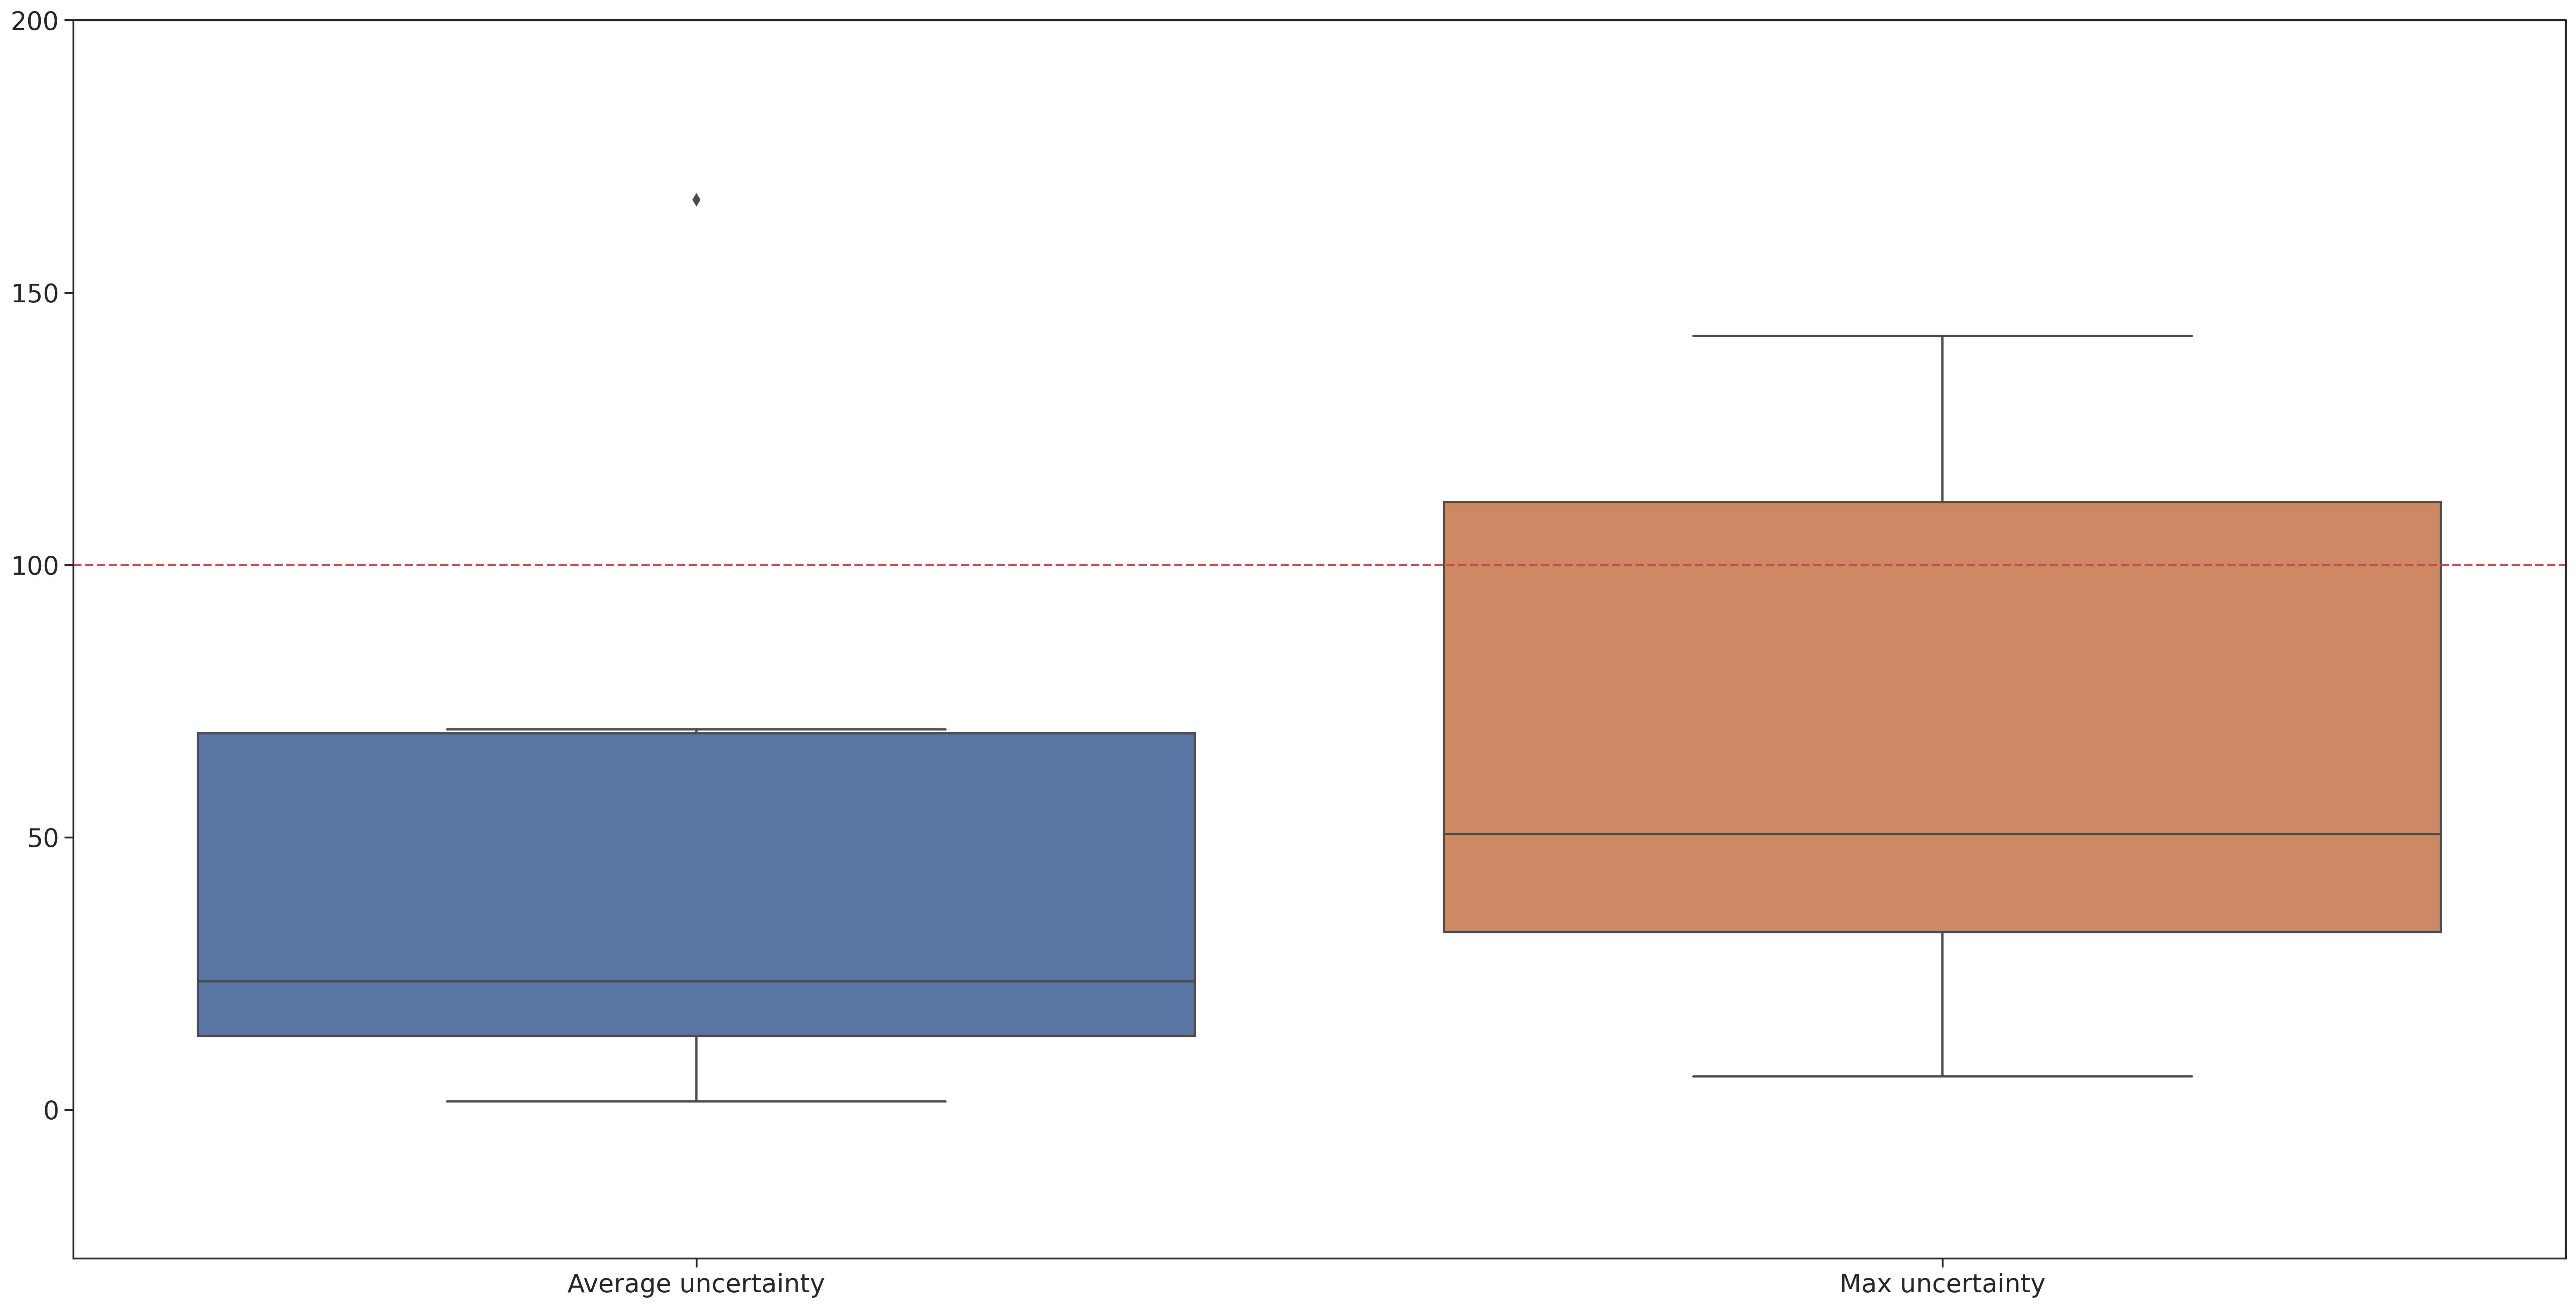

In [ ]:
display_df = results

fig, ax = plt.subplots(figsize=(30, 15))

h = sns.boxplot(data=display_df[["Average uncertainty",	"Max uncertainty"]], ax=ax,)
plt.axhline(y=100, c='r', linestyle='--')
plt.ylim(top=200)
#h.set_yscale("log")

"""
h.set_axis_labels('Experimental yields', 'Predicted yields')
h.ax_joint.set_xticks([0, 20, 40, 60, 80, 100])
h.ax_joint.set_yticks([0, 20, 40, 60, 80, 100])
#h.ax_marg_x.set_facecolor("white")
#h.ax_marg_y.set_facecolor("white")
"""
fig_path = images_path + '/uncertainties_global.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')

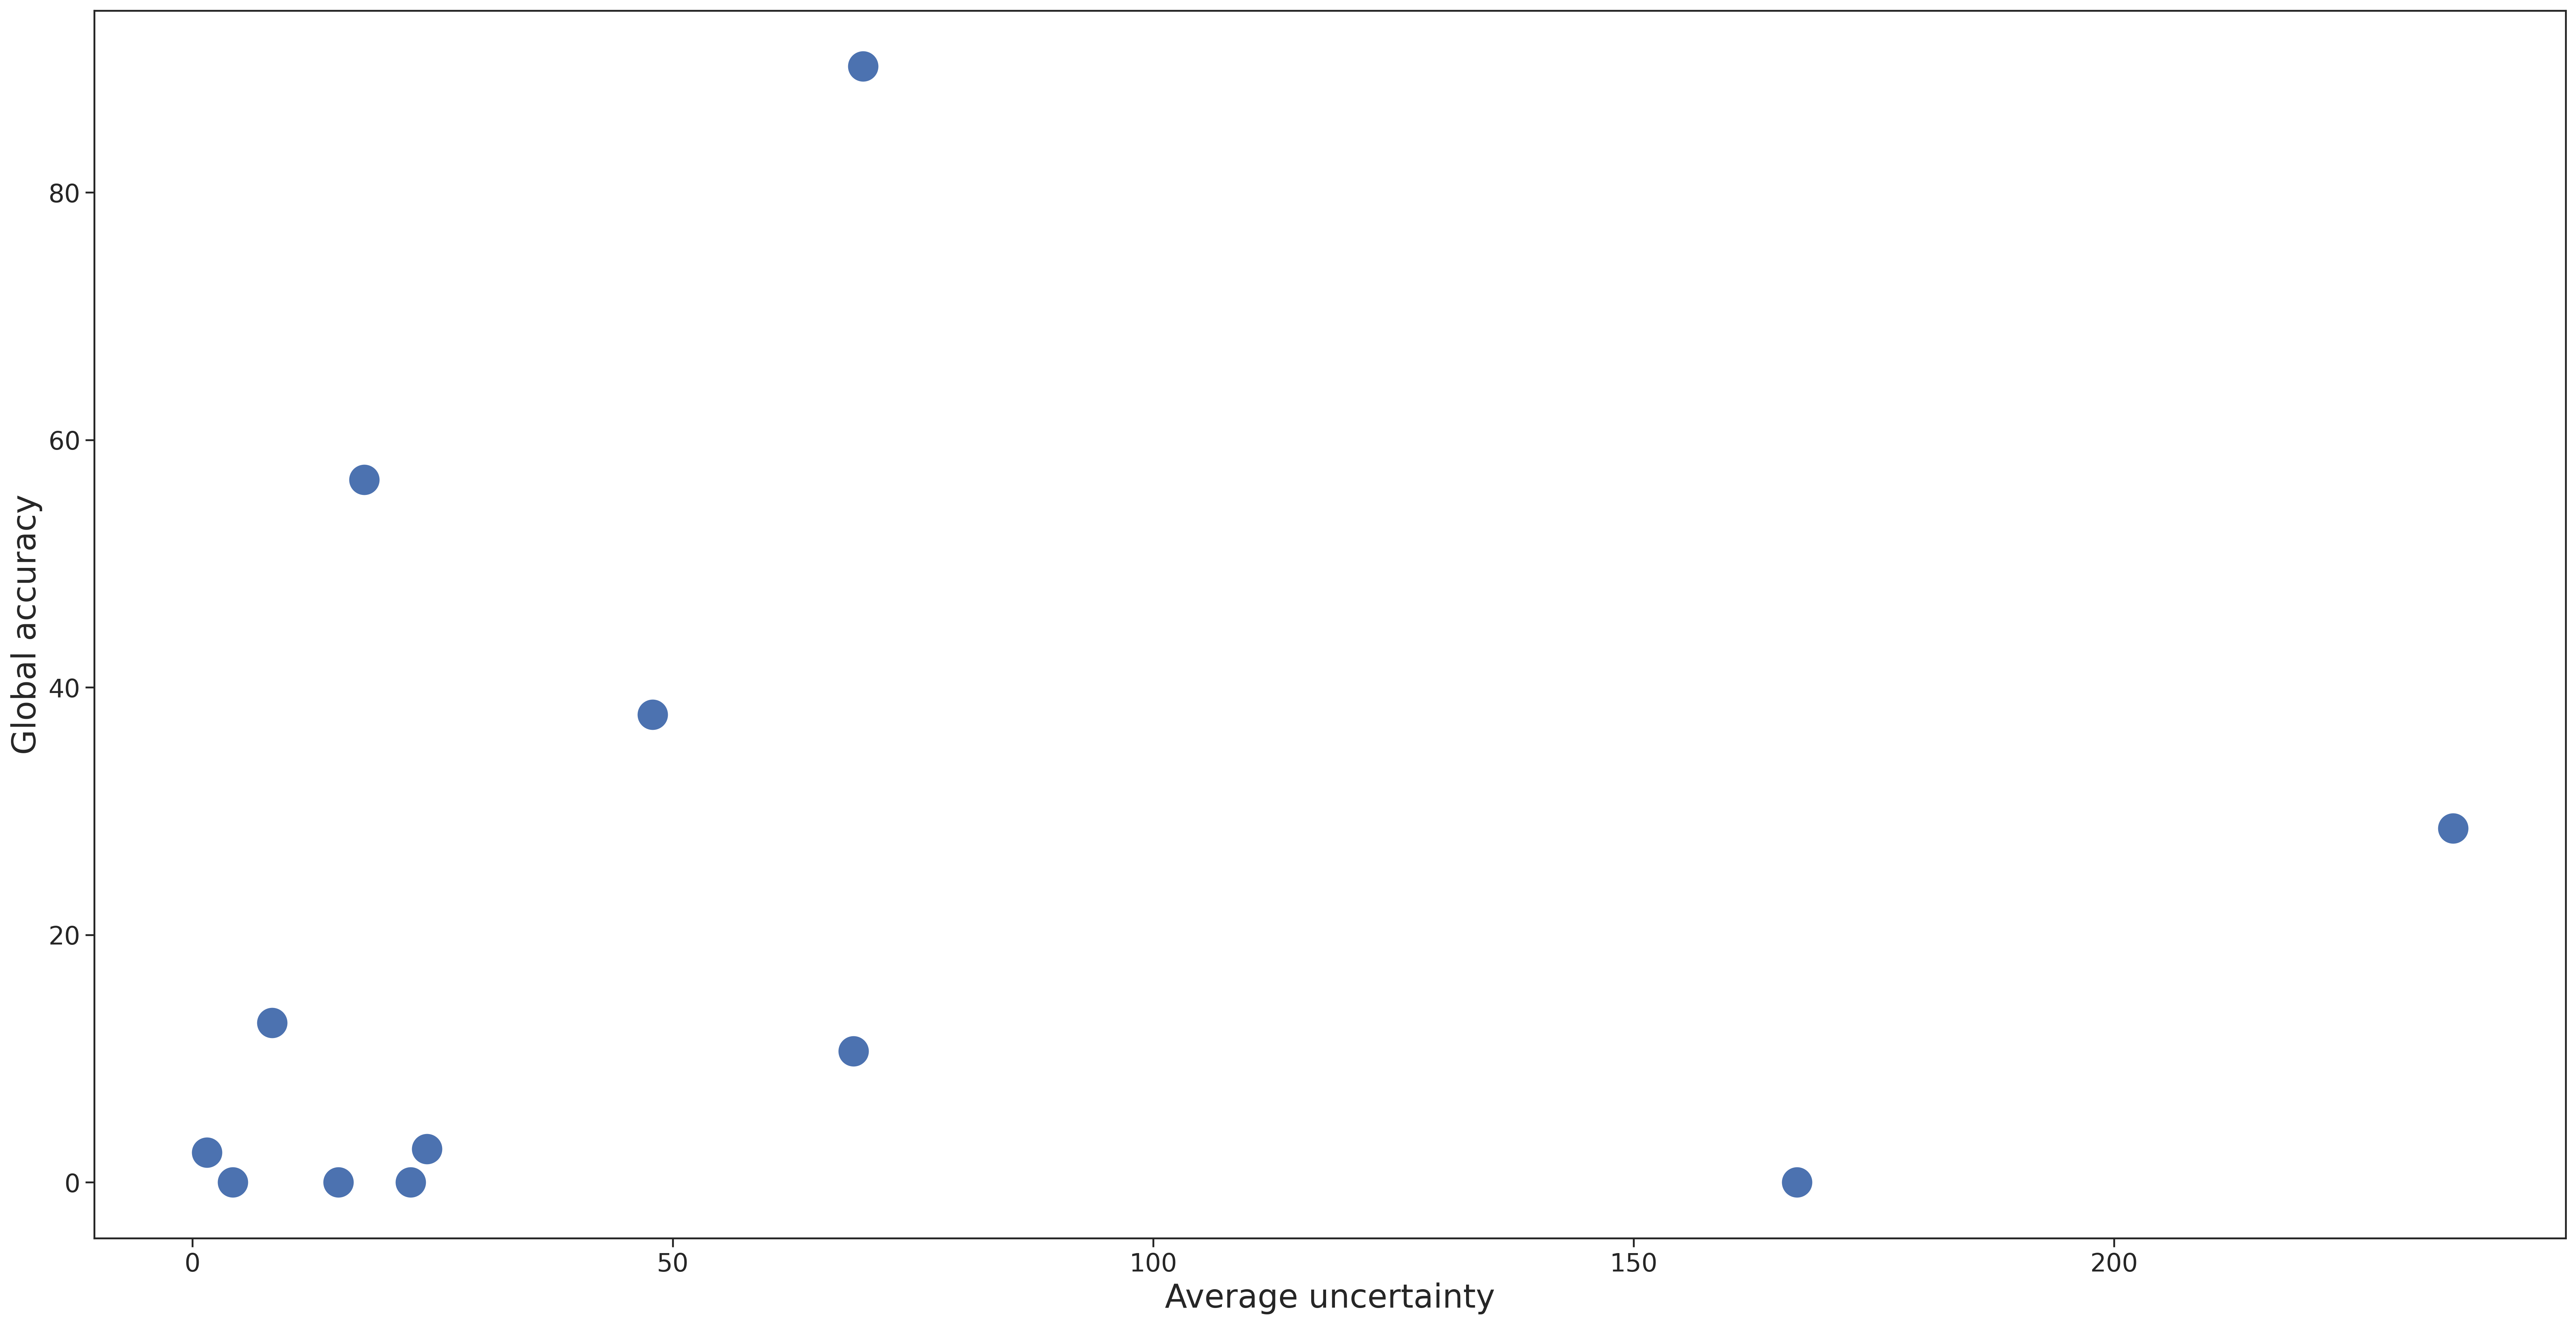

In [ ]:
display_df = results

fig, ax = plt.subplots(figsize=(30, 15))

h = sns.scatterplot(data=display_df, x="Average uncertainty", y="Global accuracy", s=500)
def label_point(x, y, val, ax):
    for point in zip(x, y , val):
        ax.text(point[0]-10, point[1], str(point[2])[10:])

#label_point(display_df["Average uncertainty"].values, display_df["Global accuracy"].values, display_df.index, plt.gca()) 

#h.set_yscale("log")

"""
h.set_axis_labels('Experimental yields', 'Predicted yields')
h.ax_joint.set_xticks([0, 20, 40, 60, 80, 100])
h.ax_joint.set_yticks([0, 20, 40, 60, 80, 100])
#h.ax_marg_x.set_facecolor("white")
#h.ax_marg_y.set_facecolor("white")
"""
fig_path = images_path + '/accuracy_vs_uncertainty.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')

In [ ]:
urls = {"2020/04/29": "https://raw.githubusercontent.com/evaluation-modelisation-covid/france/gh-pages/paper_models/data/2020_04_29/corrected_scenarios.csv",
        "2020/10/30": "https://docs.google.com/spreadsheets/d/e/2PACX-1vS_Rt5iSm-hUh_E3-bEoiGrTudD6y8nH9DSOmv3lnoXarpiE-j0fRXO9Eue6OBcQETgEhdA2mdHj9d_/pub?output=csv",
        "2021/01/16": "https://docs.google.com/spreadsheets/d/e/2PACX-1vSBmQAk_SHl2yOol1UxaTPSbVojGyyjxXlr5v_BItghFzaD7e2T1w9ZxwiTDlzC0afmbOcOIVRcoRPX/pub?output=csv",
        "2021/02/02": "https://docs.google.com/spreadsheets/d/e/2PACX-1vQYFaMgqbJ01L3bDpWXELQ-6c6vfCD7q1u77i7BgmdAXZ2ueRZmUx4u6R3h7HYgSxrQ5loxjiJ8MwRF/pub?output=csv",
        "2021/02/08": "https://docs.google.com/spreadsheets/d/e/2PACX-1vSJ1il5EWk7rmkQeDc4KKd4v2VUmhrnDsFe2eHWTrIYsnIcb3c1kYcfVc09b7TybWlDd6hqDqSHPVAV/pub?output=csv",
        "2021/02/23": "https://docs.google.com/spreadsheets/d/e/2PACX-1vT97zHSANWwOkblR6uQ8VetzLkrZxtP76b3YwfgbNG3J_CM2_6T_qh79IfkPzsHctCODllWvF2A4F3R/pub?output=csv",
        "2021/04/26": "https://docs.google.com/spreadsheets/d/e/2PACX-1vTHLEMcfhH1Qf8TYFVhinn99BtDCvoJNU_zvbM9xSxjj7DlDj7IRbVmoi806fa3vZTHnHRcHt3oI_IM/pub?output=csv",
        "2021/05/21": "https://docs.google.com/spreadsheets/d/e/2PACX-1vRAPzAszfERutu6mmn68rzYUkN0LEeUIy5ZdmzgpCc7yjsbzO-HmnWnRWz78OdQU_FHR_coNVTO8qvh/pub?output=csv",
        "2021/07/26": "https://docs.google.com/spreadsheets/d/e/2PACX-1vTTLxGqnGQsDkiTfxbO69FCIbEGXgsY9pev441vyQPsL50nRPfd5-CxXv0njIY9GTgZjUk0TyMNwBhc/pub?output=csv",
        "2021/08/05": "https://docs.google.com/spreadsheets/d/e/2PACX-1vTAdMGQv0dkh2yAUaV_5kDlmJ2sSEHB4gHZZlscIyO81mBYJhdiS7ZrXJuZ4V5m6cQrHt01qYvf-hrc/pub?output=csv",
        "2021/10/04": "https://docs.google.com/spreadsheets/d/e/2PACX-1vRhSdbezponifKXA-XoLq0uTWj8iwl_NE4ACmYyMnpHqSGQKROsPjewgkjsltd818gk16qOfVBuQb6D/pub?output=csv",
        "2022/01/07": "https://docs.google.com/spreadsheets/d/e/2PACX-1vSpQMtbajcnEJDOhe6c6WgRm_khff3hl1J4pjyRVo3Ee53z_pdIixNJZuHha1gRUisylRHgDnKa9zc-/pub?output=csv"}

normalizations = {"2020/04/29": icu_normalization,
        "2020/10/30": icu_normalization,
        "2021/01/16": new_hosp_normalization,
        "2021/02/02": new_hosp_normalization,
        "2021/02/08": new_hosp_normalization,
        "2021/02/23": new_hosp_normalization,
        "2021/04/26": new_hosp_normalization,
        "2021/05/21": new_hosp_normalization,
        "2021/07/26": icu_normalization,
        "2021/08/05": icu_normalization,
        "2021/10/04": icu_normalization,
        "2022/01/07": icu_normalization}




dict_values([70.0, 70.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 70.0, 70.0, 70.0, 70.0])

In [12]:
dates = normalizations.keys()
endpoints = ["ICU beds", "ICU beds", "Hospital admissions",  "Hospital admissions",  "Hospital admissions",  "Hospital admissions",  "Hospital admissions",  "Hospital admissions", "ICU beds", "ICU beds", "ICU beds", "ICU beds"]
public = ["No", "No", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"]
df = pd.DataFrame(zip(dates, endpoints, public), columns =['Date', 'Endpoint', 'Public'])
print(df.to_latex(
    formatters={"name": str.upper},
    float_format="{:.1f}".format)) 

\begin{tabular}{llll}
\toprule
{} &        Date &             Endpoint & Public \\
\midrule
0  &  2020/04/29 &             ICU beds &     No \\
1  &  2020/10/30 &             ICU beds &     No \\
2  &  2021/01/16 &  Hospital admissions &    Yes \\
3  &  2021/02/02 &  Hospital admissions &    Yes \\
4  &  2021/02/08 &  Hospital admissions &    Yes \\
5  &  2021/02/23 &  Hospital admissions &    Yes \\
6  &  2021/04/26 &  Hospital admissions &    Yes \\
7  &  2021/05/21 &  Hospital admissions &    Yes \\
8  &  2021/07/26 &             ICU beds &    Yes \\
9  &  2021/08/05 &             ICU beds &    Yes \\
10 &  2021/10/04 &             ICU beds &    Yes \\
11 &  2022/01/07 &             ICU beds &    Yes \\
\bottomrule
\end{tabular}



<ipython-input-12-2962f22d6acf>:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(


In [ ]:
print(results.to_latex(
    formatters={"name": str.upper},
    float_format="{:.1f}".format))  

\begin{tabular}{lrrr}
\toprule
{} &  Average uncertainty &  Max uncertainty &  Global accuracy \\
\midrule
Scenario: 2020/04/29 &                  8.3 &             32.9 &             12.9 \\
Scenario: 2020/10/30 &                 47.9 &            101.3 &             37.8 \\
Scenario: 2021/01/16 &                235.3 &            578.1 &             28.6 \\
Scenario: 2021/02/02 &                167.0 &            396.5 &              0.0 \\
Scenario: 2021/02/08 &                 22.7 &             41.9 &              0.0 \\
Scenario: 2021/02/23 &                 17.9 &             52.2 &             56.8 \\
Scenario: 2021/04/26 &                 15.2 &             31.8 &              0.0 \\
Scenario: 2021/05/21 &                  1.5 &              6.1 &              2.4 \\
Scenario: 2021/07/26 &                 68.8 &            142.0 &             10.6 \\
Scenario: 2021/08/05 &                 69.8 &            101.4 &             90.2 \\
Scenario: 2021/10/04 &                  4.2

<ipython-input-13-2fb31e6f3fbc>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results.to_latex(


In [ ]:
df_low_scenario = compute_metrics_all_scenarios(urls)

In [ ]:
print(df_low_scenario.to_latex(
    formatters={"name": str.upper},
    float_format="{:.1f}".format)) 

\begin{tabular}{lrrrr}
\toprule
{} &  MAE &  RMSE &    ME &  Max Error \\
\midrule
Scenario: 2020/04/29 &  1.4 &   1.6 &  -0.5 &        2.7 \\
Scenario: 2020/10/30 &  8.0 &   9.1 &   0.5 &       18.5 \\
Scenario: 2021/01/16 & 29.2 &  31.8 &  -0.7 &       45.3 \\
Scenario: 2021/02/02 & 32.9 &  37.1 &  32.9 &       58.2 \\
Scenario: 2021/02/08 &  7.9 &   8.1 &   7.9 &        9.8 \\
Scenario: 2021/02/23 &  5.6 &   6.0 &  -5.2 &        8.3 \\
Scenario: 2021/04/26 &  5.1 &   5.2 &   5.1 &        7.1 \\
Scenario: 2021/05/21 & 10.6 &  11.0 & -10.6 &       15.0 \\
Scenario: 2021/07/26 &  6.6 &   7.1 &   4.7 &       10.4 \\
Scenario: 2021/08/05 &  4.9 &   5.9 &  -4.9 &        9.2 \\
Scenario: 2021/10/04 & 10.4 &  12.2 & -10.4 &       24.1 \\
Scenario: 2022/01/07 & 11.4 &  12.7 &  11.3 &       19.7 \\
\bottomrule
\end{tabular}



<ipython-input-15-9c62f6a65be5>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_low_scenario.to_latex(


In [ ]:
df_median_scenario = compute_metrics_all_scenarios(urls, scenario_name="median")

In [ ]:
print(df_median_scenario.to_latex(
    formatters={"name": str.upper},
    float_format="{:.1f}".format)) 

\begin{tabular}{lrrrr}
\toprule
{} &   MAE &  RMSE &    ME &  Max Error \\
\midrule
Scenario: 2020/04/29 &   2.9 &   3.9 &   1.1 &       11.1 \\
Scenario: 2020/10/30 &  24.5 &  26.5 &  24.5 &       34.8 \\
Scenario: 2021/01/16 & 124.7 & 169.3 & 116.9 &      334.3 \\
Scenario: 2021/02/02 & 116.4 & 144.5 & 116.4 &      256.4 \\
Scenario: 2021/02/08 &  19.3 &  19.6 &  19.3 &       25.6 \\
Scenario: 2021/02/23 &   8.1 &  11.2 &   3.7 &       29.7 \\
Scenario: 2021/04/26 &  12.7 &  13.3 &  12.7 &       19.3 \\
Scenario: 2021/05/21 &   9.2 &  10.1 &  -9.1 &       15.6 \\
Scenario: 2021/07/26 &  40.3 &  50.6 &  39.1 &       79.3 \\
Scenario: 2021/08/05 &  30.0 &  32.4 &  30.0 &       42.8 \\
Scenario: 2021/10/04 &   8.3 &   9.7 &  -8.3 &       18.3 \\
Scenario: 2022/01/07 &  23.5 &  27.1 &  23.5 &       42.3 \\
\bottomrule
\end{tabular}



<ipython-input-17-2718e1981dd3>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_median_scenario.to_latex(


In [ ]:
df_second_order = compute_metrics_all_scenarios(urls, scenario_name="2nd order")

In [ ]:
df_first_order = compute_metrics_all_scenarios(urls, scenario_name="1st order")

In [ ]:
df_constant = compute_metrics_all_scenarios(urls, scenario_name="Constant")
df_constant

,MAE,RMSE,ME,Max Error
Scenario: 2020/04/29,13.8,14.8,13.8,19.5
Scenario: 2020/10/30,14.0,16.8,-13.5,27.4
Scenario: 2021/01/16,37.1,39.5,-37.1,54.4
Scenario: 2021/02/02,15.0,18.4,-15.0,35.1
Scenario: 2021/02/08,3.1,3.2,3.1,4.1
Scenario: 2021/02/23,6.4,8.1,-6.4,15.6
Scenario: 2021/04/26,24.5,25.9,24.5,34.1
Scenario: 2021/05/21,44.1,47.2,44.1,68.6
Scenario: 2021/07/26,12.0,12.9,-12.0,17.5
Scenario: 2021/08/05,8.4,9.1,-8.4,12.2


In [ ]:
df_high_scenario = compute_metrics_all_scenarios(urls, metrics=metrics, scenario_name="high")

In [ ]:
print(df_high_scenario.to_latex(
    formatters={"name": str.upper},
    float_format="{:.1f}".format)) 

\begin{tabular}{lrrrr}
\toprule
{} &   MAE &  RMSE &    ME &  Max Error \\
\midrule
Scenario: 2020/04/29 &   9.4 &  15.4 &   7.7 &       35.3 \\
Scenario: 2020/10/30 &  48.4 &  55.5 &  48.4 &       83.3 \\
Scenario: 2021/01/16 & 237.5 & 317.5 & 234.6 &      623.4 \\
Scenario: 2021/02/02 & 199.9 & 252.8 & 199.9 &      454.7 \\
Scenario: 2021/02/08 &  30.6 &  31.7 &  30.6 &       46.6 \\
Scenario: 2021/02/23 &  15.8 &  22.4 &  12.6 &       55.8 \\
Scenario: 2021/04/26 &  20.3 &  22.0 &  20.3 &       35.2 \\
Scenario: 2021/05/21 &   9.2 &  10.1 &  -9.1 &       15.6 \\
Scenario: 2021/07/26 &  74.3 &  94.8 &  73.6 &      149.9 \\
Scenario: 2021/08/05 &  64.9 &  70.6 &  64.9 &       93.2 \\
Scenario: 2021/10/04 &   6.2 &   7.2 &  -6.2 &       12.5 \\
Scenario: 2022/01/07 &  35.7 &  41.7 &  35.7 &       65.8 \\
\bottomrule
\end{tabular}



<ipython-input-22-a36406ec9f5f>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_high_scenario.to_latex(


In [ ]:
compute_metrics_all_scenarios(urls, scenario_name="median", n_days=14)

,MAE,RMSE,ME,Max Error
Scenario: 2020/04/29,1.4,1.5,-1.4,2.2
Scenario: 2020/10/30,11.1,12.3,11.1,20.2
Scenario: 2021/01/16,124.7,169.3,116.9,334.3
Scenario: 2021/02/02,116.4,144.5,116.4,256.4
Scenario: 2021/02/08,17.2,17.3,17.2,20.0
Scenario: 2021/02/23,5.2,5.3,-5.2,6.5
Scenario: 2021/04/26,7.4,7.6,7.4,10.1
Scenario: 2021/05/21,11.4,11.7,-11.4,15.6
Scenario: 2021/07/26,2.8,3.1,-2.8,4.7
Scenario: 2021/08/05,12.3,13.3,12.3,20.6


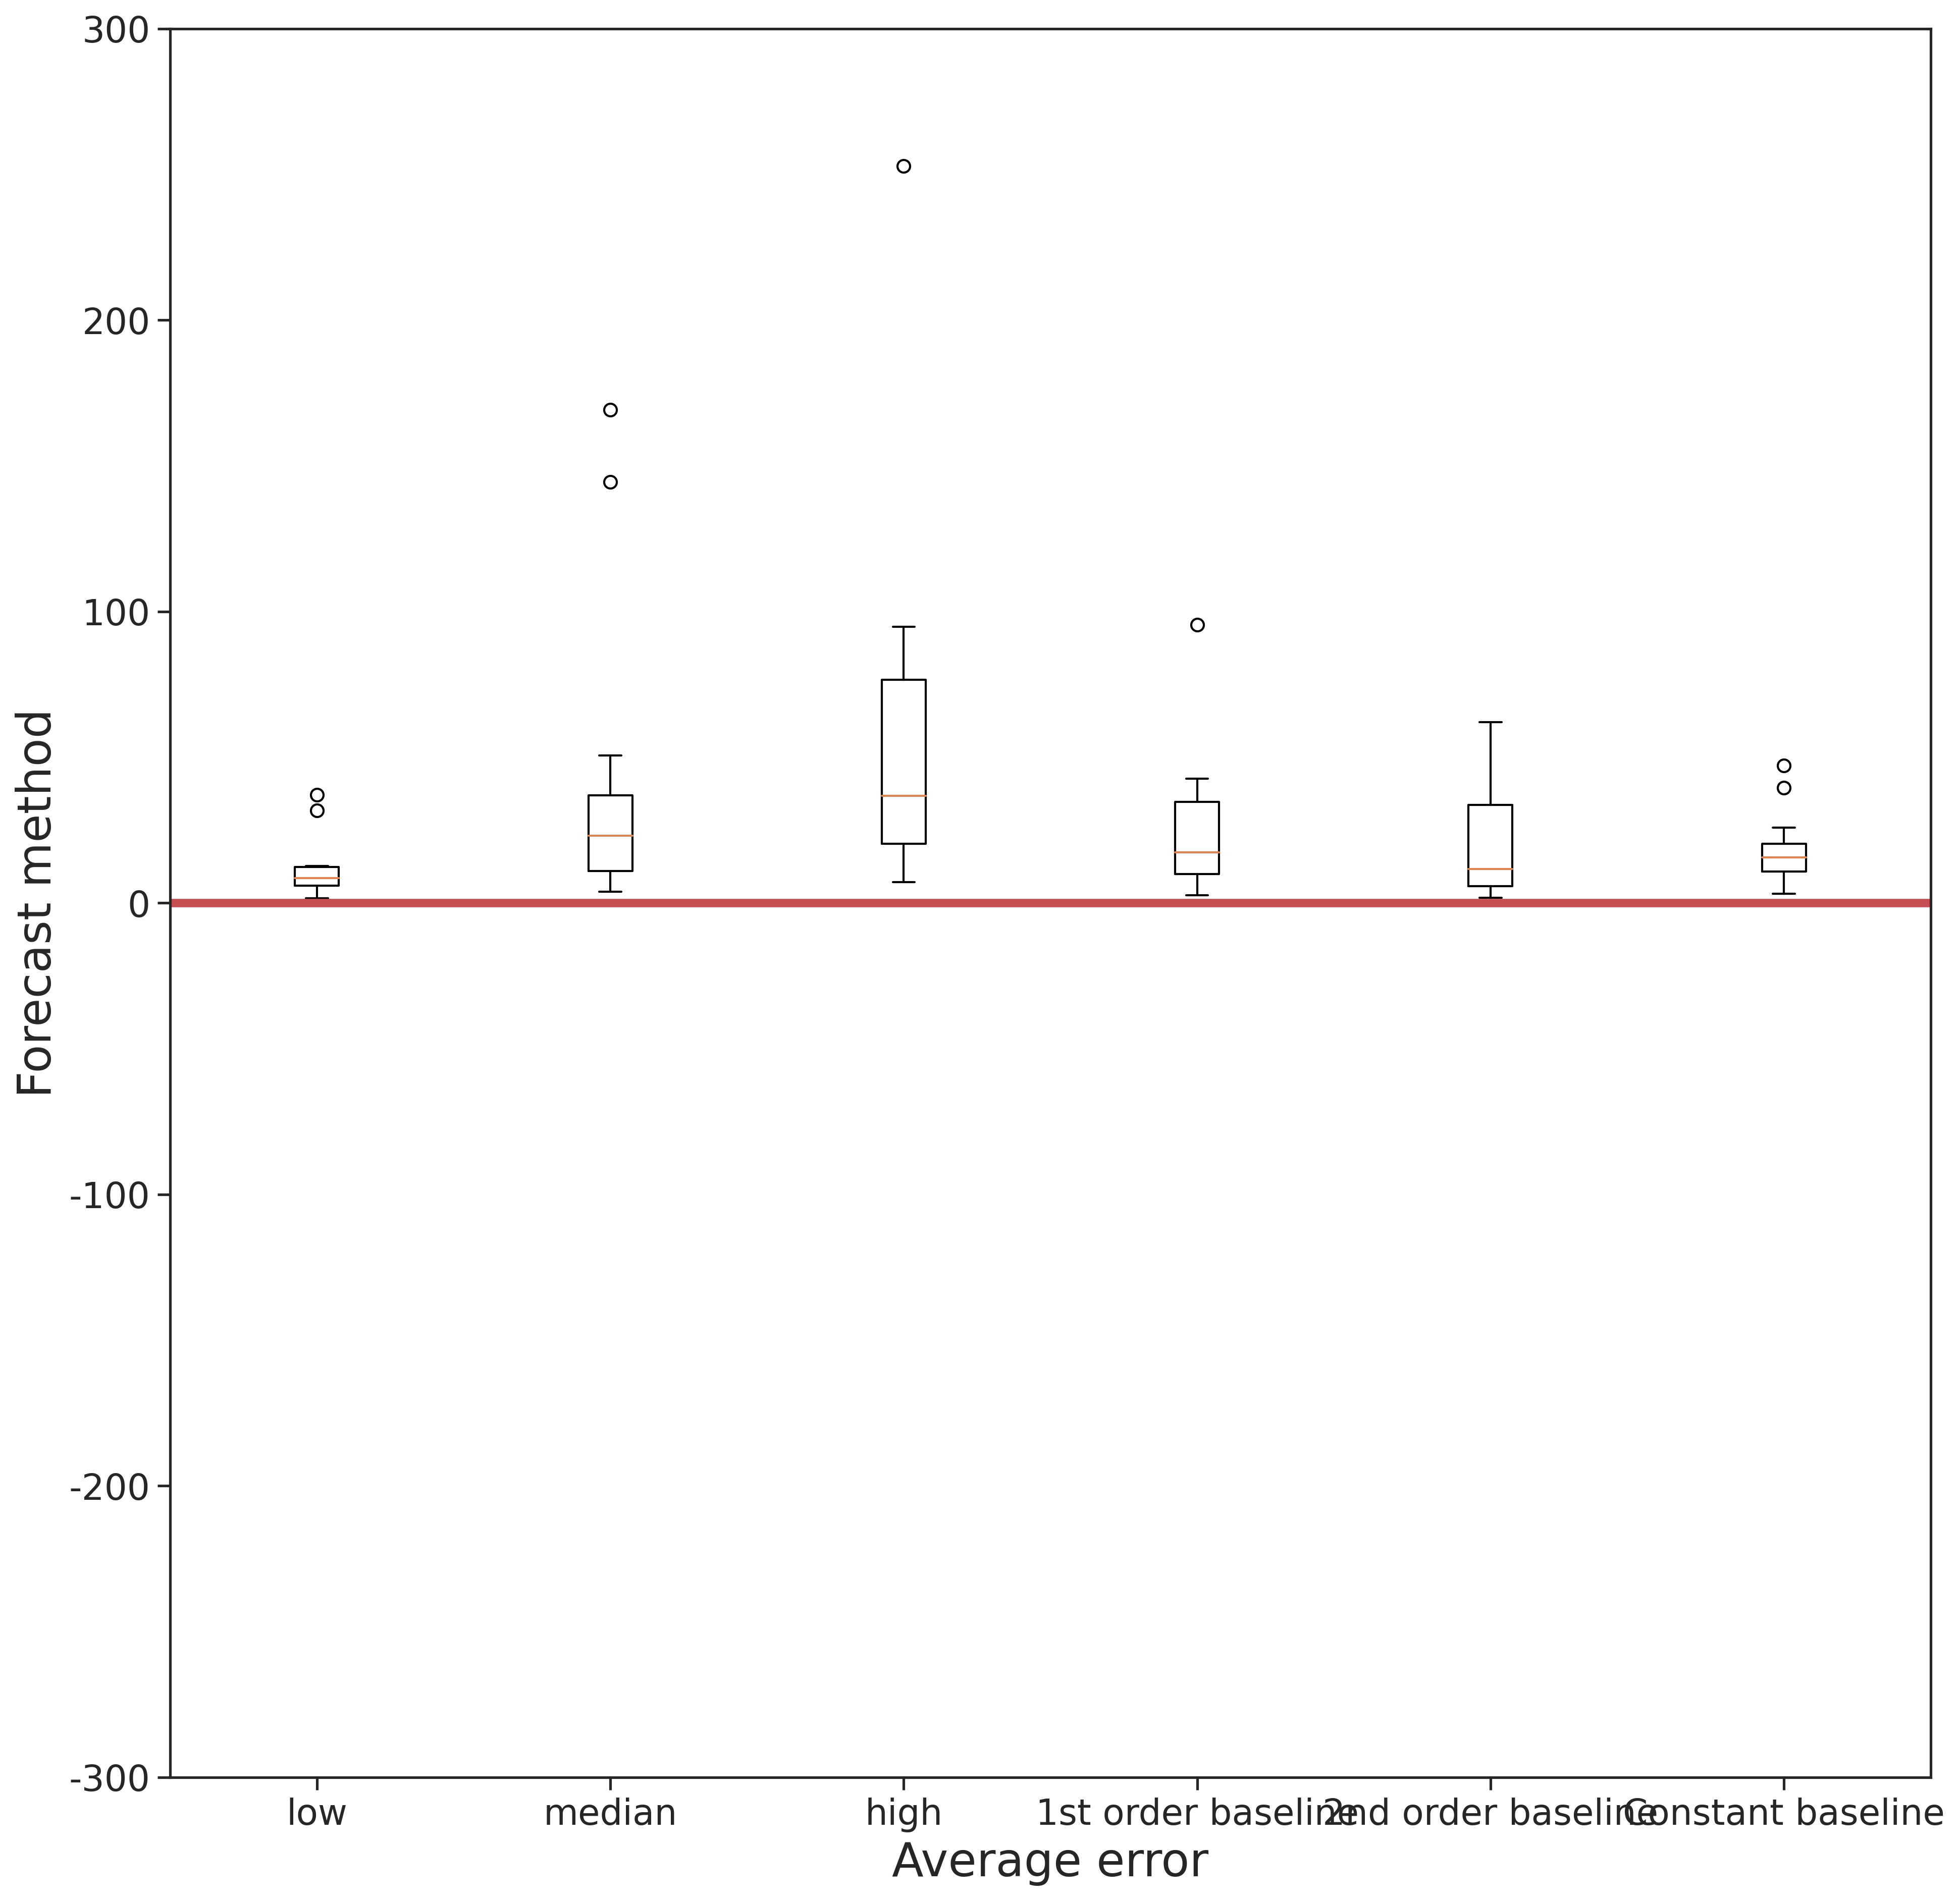

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
map = {"low": df_low_scenario.iloc[:, 1].values, "median": df_median_scenario.iloc[:, 1].values, "high": df_high_scenario.iloc[:, 1].values,
       "1st order baseline": df_first_order.iloc[:, 1].values, "2nd order baseline": df_second_order.iloc[:, 1].values, "Constant baseline": df_constant.iloc[:, 1].values}

for i, (k, v) in enumerate(map.items()):
  ax.boxplot(v, positions=[i])

ax.set_xlabel('Average error')
ax.set_ylabel('Forecast method')
ax.axhline(0, linewidth=4, color='r')
ax.set_ylim(-300, 300)
ax.set_xticklabels(list(map.keys()))
#plt.setp(['whiskers'], color='k', linestyle='-')
#plt.setp(bp['fliers'], markersize=3.0)
plt.show()

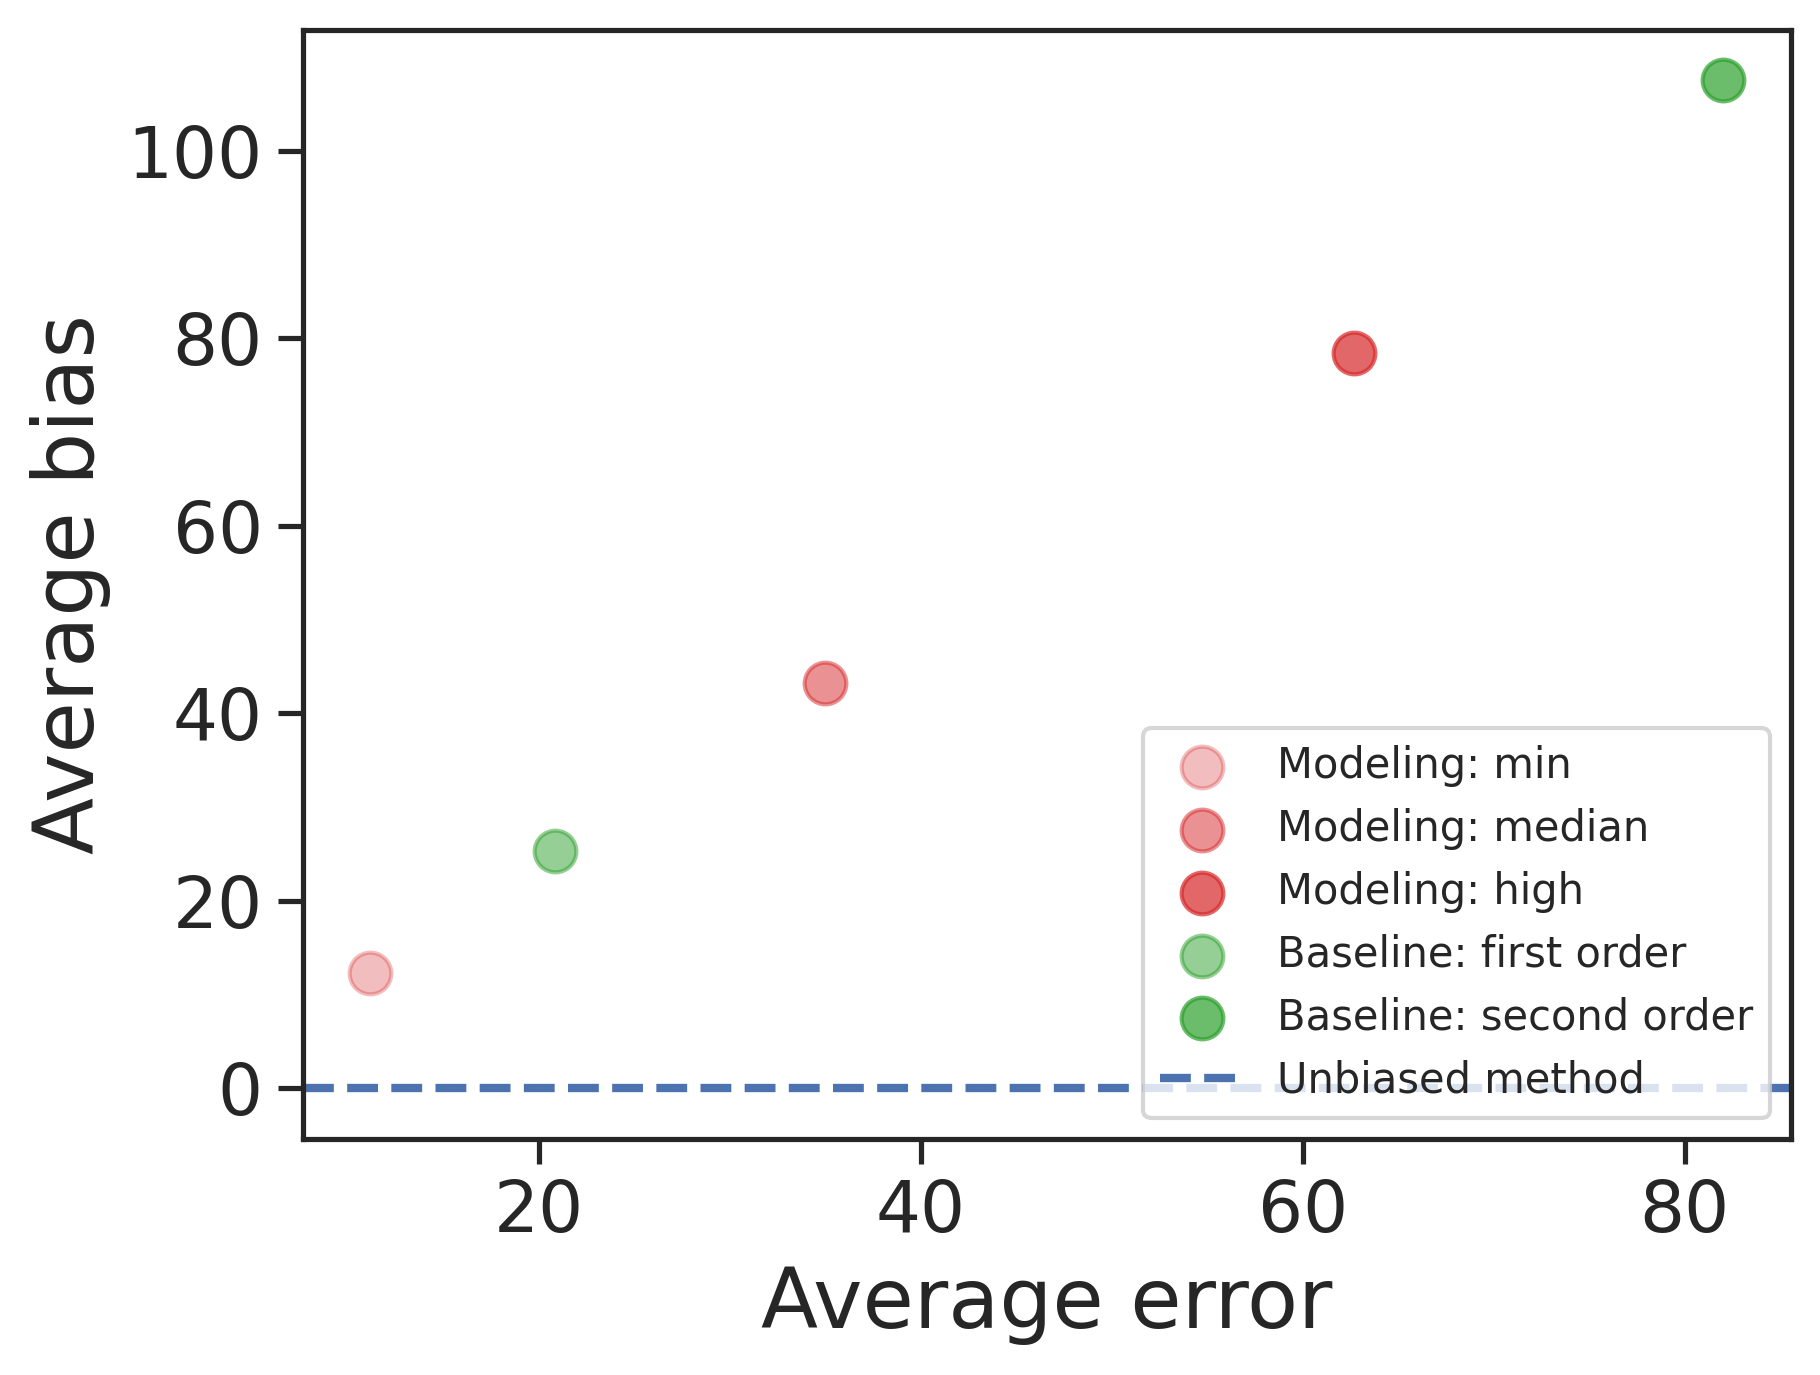

In [ ]:
dfs = [df_low_scenario, df_median_scenario, df_high_scenario, df_first_order, df_second_order]

fig, ax = plt.subplots()
x = [np.mean(df.iloc[:, 0].values) for df in dfs]
y = [np.mean(df.iloc[:, 1].values) for df in dfs]

legends = ["Modeling: min", "Modeling: median", "Modeling: high", "Baseline: first order", "Baseline: second order"]
for i, a in enumerate([0.3, 0.5, 0.7]):
    ax.scatter(x[i], y[i], c="tab:red", label=legends[i],
               alpha=a, s=100)
    
for i, a in enumerate([0.5, 0.7]):
    ax.scatter(x[i+3], y[i+3], c="tab:green", label=legends[i+3],
               alpha=a, s=100)
ax.set_xlabel("Average error", fontsize=20)
ax.set_ylabel("Average bias", fontsize=20)
ax.axhline(0, linewidth=2, color='b', linestyle="--", label="Unbiased method")
plt.legend(loc=4, fontsize=10)

plt.show()

<ipython-input-26-3917beef0b8b>:10: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(bottom=0)
<ipython-input-26-3917beef0b8b>:10: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(bottom=0)
<ipython-input-26-3917beef0b8b>:10: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(bottom=0)
<ipython-input-26-3917beef0b8b>:10: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(bottom=0)


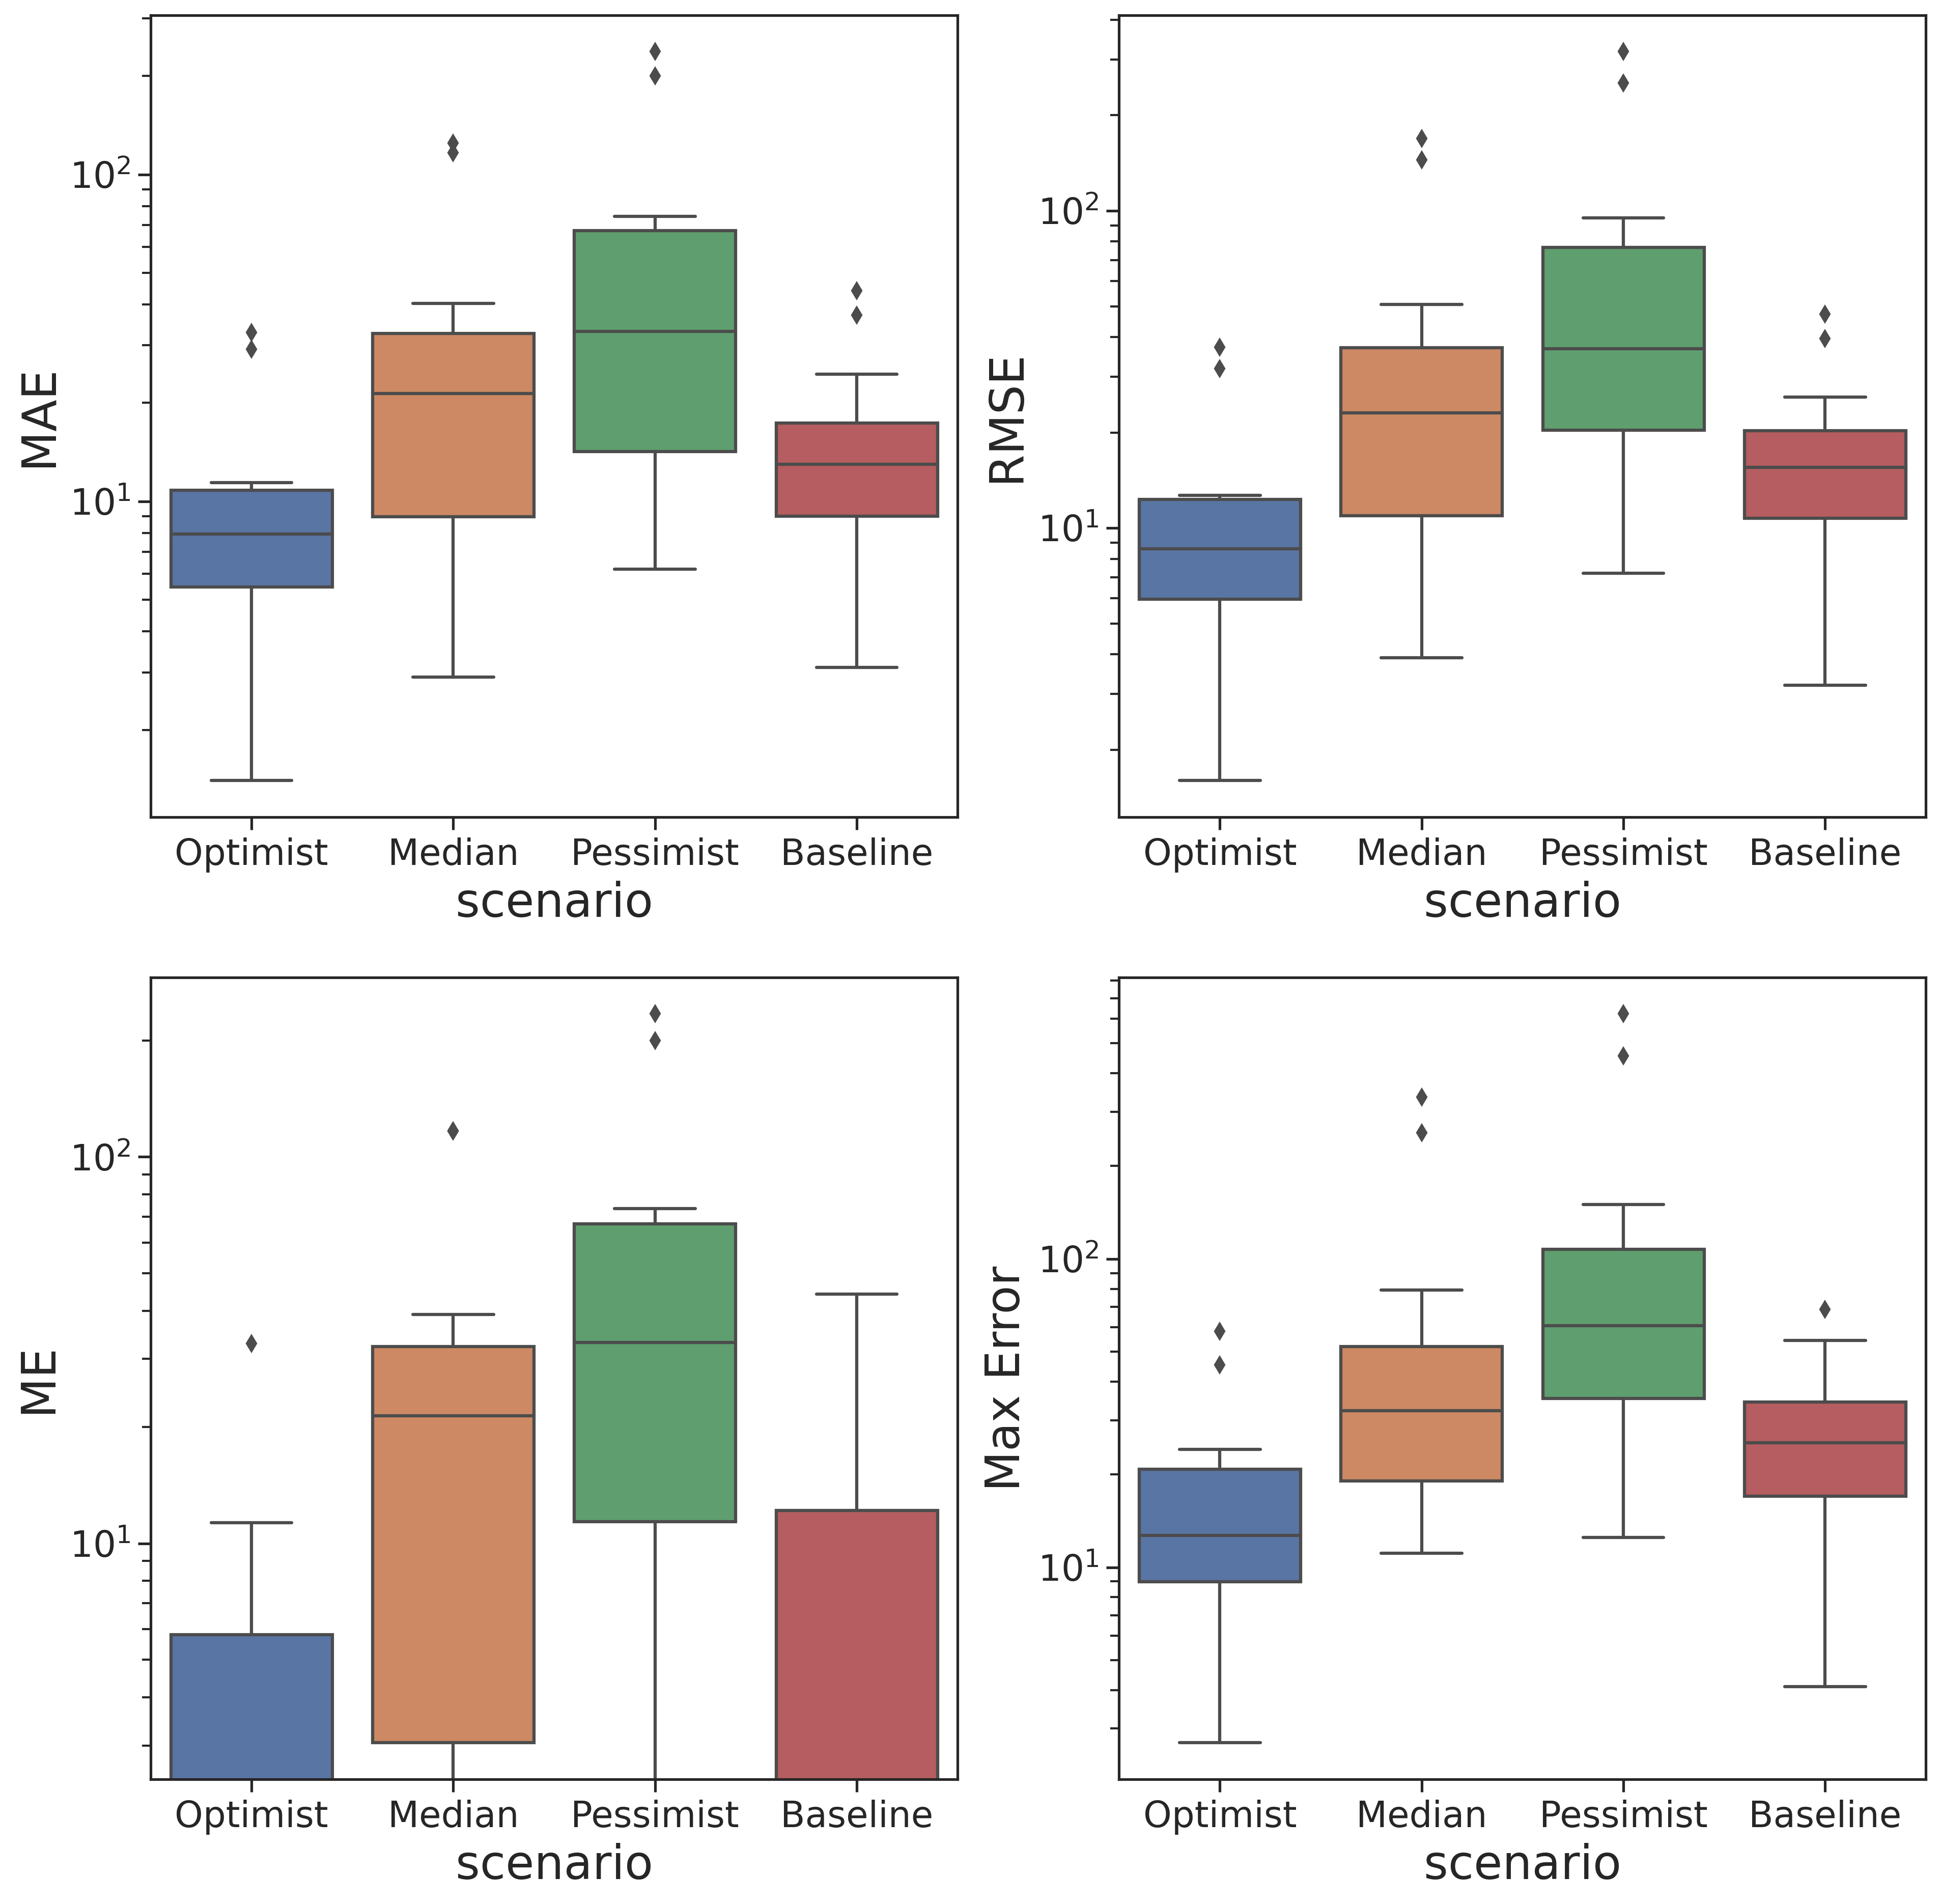

In [ ]:
display_df = pd.concat([df_low_scenario.assign(scenario='Optimist'), df_median_scenario.assign(scenario='Median'),
                        df_high_scenario.assign(scenario='Pessimist'), df_constant.assign(scenario='Baseline')], axis=0)

endpoints = ["MAE", "RMSE", "ME", "Max Error"]
fig, axes = plt.subplots(ncols=2,nrows=2, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    h = sns.boxplot(data=display_df, y=endpoints[i], x="scenario", ax=ax)
    h.set_yscale("log")
    ax.set_ylim(bottom=0)


"""
h.set_axis_labels('Experimental yields', 'Predicted yields')
h.ax_joint.set_xticks([0, 20, 40, 60, 80, 100])
h.ax_joint.set_yticks([0, 20, 40, 60, 80, 100])
#h.ax_marg_x.set_facecolor("white")
#h.ax_marg_y.set_facecolor("white")
"""
fig_path = images_path + '/average_uncertainty.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')

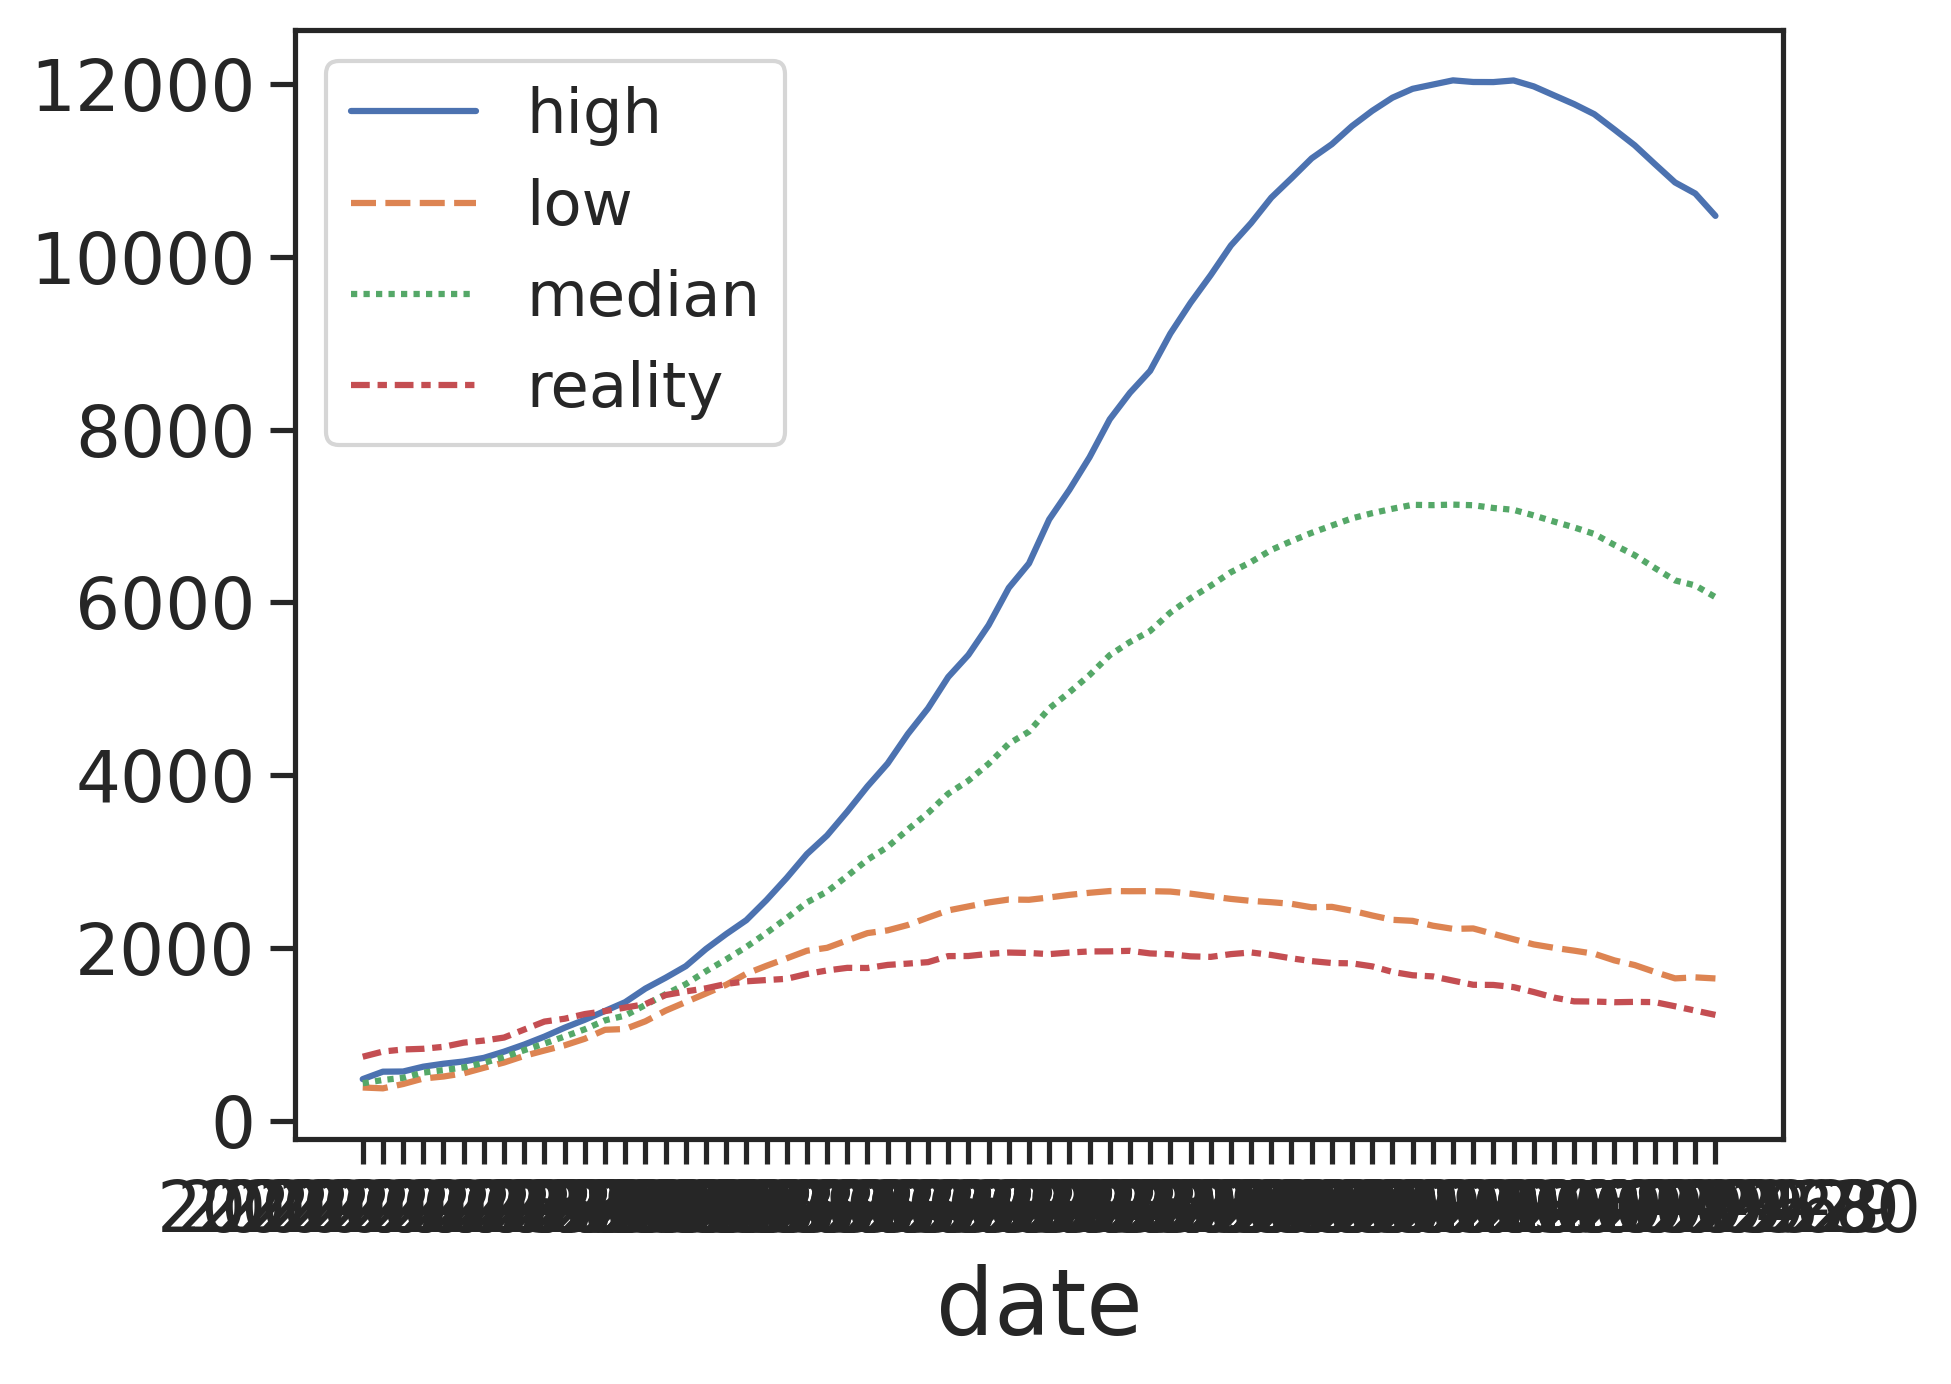

In [ ]:
df_viz = load_dataframe(url=urls["2021/07/26"])
sns.lineplot(df_viz.drop(columns=["reality_report"]))
fig_path = images_path + '/example_scenario.pdf'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')

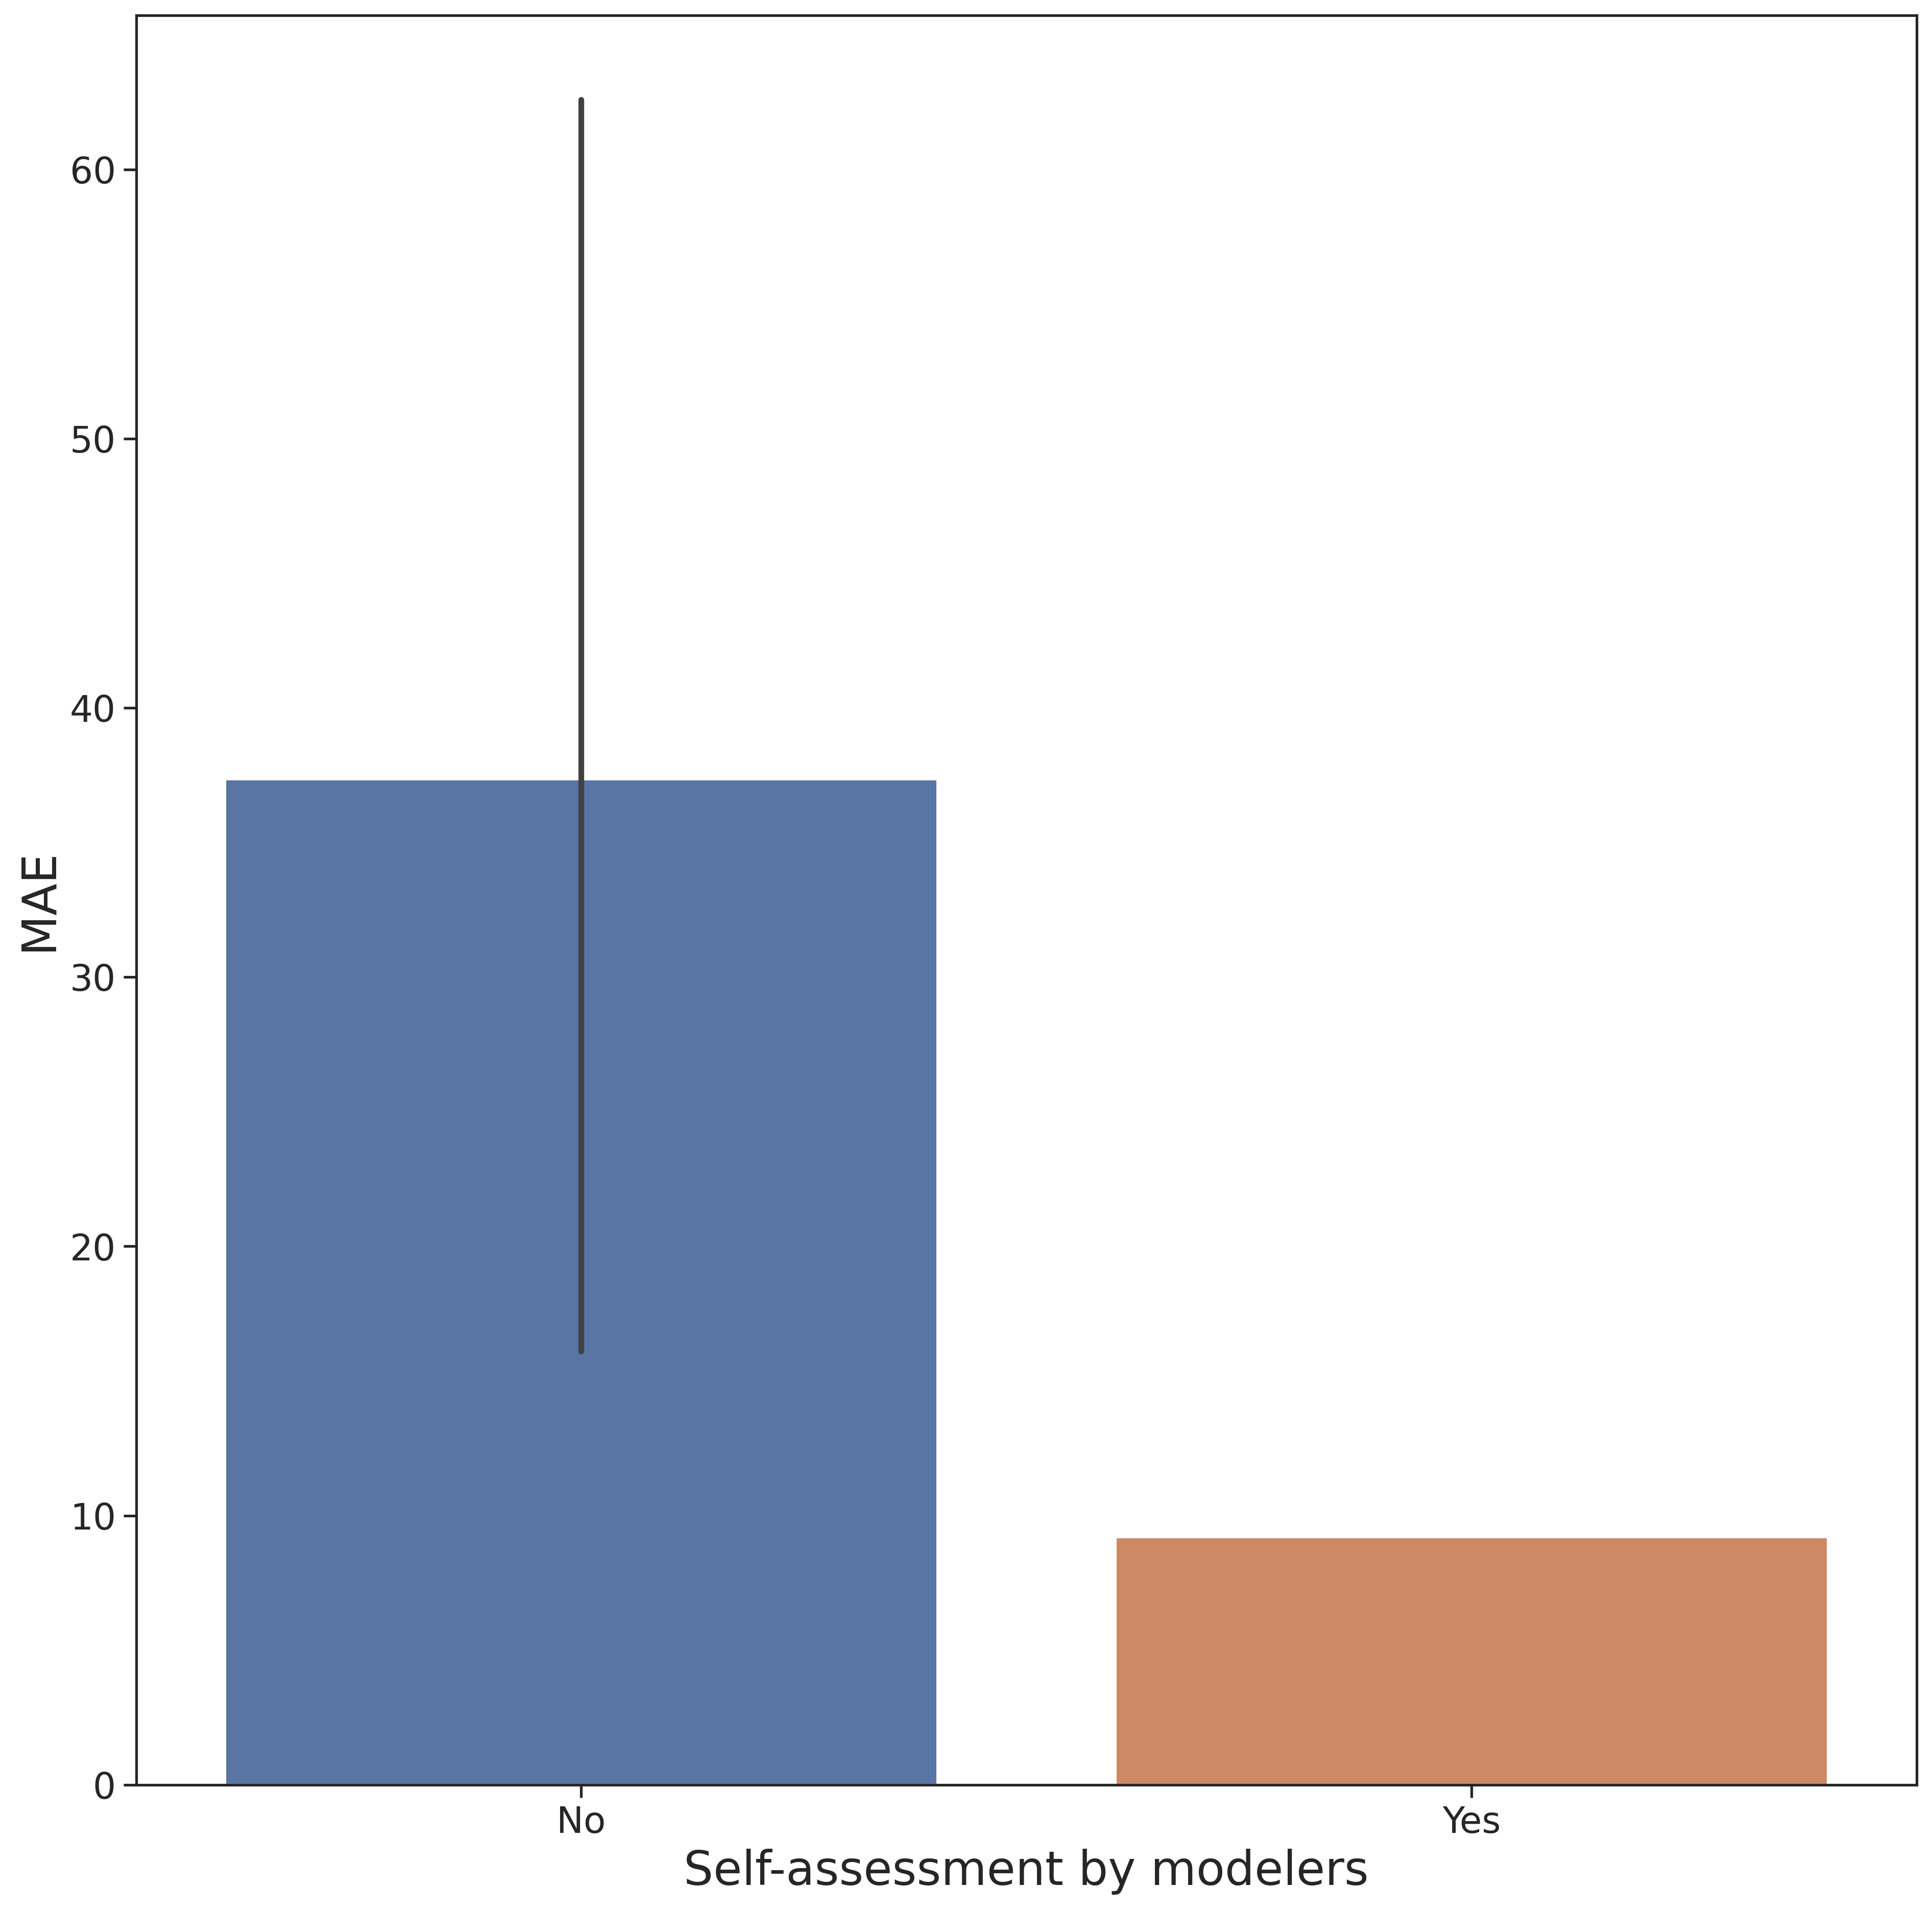

In [ ]:
df_median_scenario["Self-assessment by modelers"] = ['No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No']

fig, ax = plt.subplots(figsize=(15, 15))

h = sns.barplot(data=df_median_scenario, y="MAE", x="Self-assessment by modelers", ax=ax)


"""
h.set_axis_labels('Experimental yields', 'Predicted yields')
h.ax_joint.set_xticks([0, 20, 40, 60, 80, 100])
h.ax_joint.set_yticks([0, 20, 40, 60, 80, 100])
#h.ax_marg_x.set_facecolor("white")
#h.ax_marg_y.set_facecolor("white")
"""
fig_path = images_path + '/self_assessment_by_modelers.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')